# Notebook Description

* There are some compounds in the atmosphere which are majorly emitted as a result of human activities. Some of the compounds are Nitrogen Dioxide, Sulphur Dioxide, Methane, surface Ozone, CO2 and CO, Particulate Matter.
* Delhi, the capital of India is infamous for having one of the worst air quality index in the world. The condition is terrible in winters, as influx of polluted air and stubble burning in surrounding areas worsen the air quality even further.

# Observations

* Seasonality:We can see that there is a clearly a strong seasonal component to the concentration of pollutants show below. This can be attributed to  
    * The Concentration of Sulfur diooxide and Nitrogen dioxide show a maximum in the winter months, they reduce marginally in summer period and are lowest in monsoon period.
    * The Concentration of Carbon monoxide too show a similar cycle, although the concentrations seem to increase in the months of April-May.
    * Aerosol Index Concentrations show a positive mean in the summer months, and a negative mean in winter months. The positive value of Aerosol Index indicates the presence of UV radiation absorbing aerosols(dust,smoke etc),while a negative value indicates presence of non-absorbing aerosols. 
    
    
* The Digital Elevation Model Image shows that Delhi is flanked by hills in the south-west direction.This could possibly block dispersion of northern winds towards the south.

# References and Resources

* Delhi air pollution - Effects on health: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3612296/
* Delhi air quality analysis: https://currentscience.ac.in/Volumes/109/05/0902.pdf
* Article : https://disc.gsfc.nasa.gov/information/glossary?title=Aerosol%20Index
* Paper : https://www.sciencedirect.com/science/article/pii/S0303243419313571
* Air pollution article: https://aaqr.org/articles/aaqr-20-04-oa-0139
* calculating air quality : https://www.kaggle.com/rohanrao/calculating-aqi-air-quality-index-tutorial?scriptVersionId=41199538
* news report :https://www.business-standard.com/article/current-affairs/delhi-s-no2-pollution-increased-by-125-in-one-year-finds-study-121070700521_1.html

# Imports 

In [1]:

import requests
import numpy as np 
import os 
import pickle
import pandas as pd
from collections import defaultdict

import ee 
import matplotlib.pyplot as plt 
import folium
import branca.colormap as cmp
from scipy import optimize
from folium.plugins import MarkerCluster,HeatMap,HeatMapWithTime
from IPython import display


# Note: 
* The layers on top of folium maps will dissapear in couple of days. Please re-run the notebook on your end to visualize the results.

# Helper Functions

In [2]:
#Earth Engine helper functions

# setup to add ee layer to folium

def add_ee_layer(self, ee_image_object, vis_params, name,opacity=0.75):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
      tiles=map_id_dict['tile_fetcher'].url_format,
      attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name=name,
      opacity=opacity,
      overlay=True,
      control=True
    ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer


def get_best_image(image_collection,
                   year,
                   area_of_interest,
                   month=10):
    '''filter the best image( with the least cloud cover value) for the given year and given month'''

    start_date = ee.Date.fromYMD(**{
        'day':1 ,
        'month': month,
        'year' : year})
    end_date = ee.Date.fromYMD(**{
        'day':30 ,
        'month': month,
        'year' : year})
    
    
    if not area_of_interest:
        # sort image by asc order of cloud pixel values
        img = image_collection.filterDate(start_date,end_date).sort('CLOUD_COVER').first()
    else:
        img = image_collection.filterDate(start_date,end_date).sort('CLOUD_COVER').first().clip(area_of_interest)
        
    
    return img 

In [3]:
#other 
def show_layer_on_folium(map_bounds,
                        layer,
                        title,
                        viz_params,
                        colormap=None,
                        download=True,
                         opacity=0.90,
                        basemap= 'OpenStreetMap'):
    
    #initiate a map
    map_1=folium.Map(tiles=basemap)
    
    #fit map to our geometry
    folium.FitBounds(bounds=map_bounds).add_to(map_1)
    
    #add ee layer 
    map_1.add_ee_layer(ee_image_object=layer,
                       vis_params=viz_params,
                       name=title,
                      opacity=opacity)
    
    #add layer control
    map_1.add_child(folium.LayerControl())
    
    if download:
        map_1.save(f'{title}.html')
        return None
    else:
        return map_1

In [4]:
#getting data 

def get_df(img_collection_info,
           bands):
    '''get a dataframe of values for the given Bands'''
    
    
    df = pd.DataFrame(img_collection_info)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *bands]].dropna()

    # Convert the data to numeric values.
    for band in bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    #lat-long of point as location
    df['location']=df.apply(lambda x : (x['latitude'],x['longitude']),axis=1)
    
    
    # Keep the columns of interest.
    df = df[['datetime','location','longitude', 'latitude',  *bands]]

    return df

def mean_value(df,band):
    '''Taking the mean value for a band for each groupby (by date) object for that region,so that we have a mean value of given band for that region'''
    
    
    #mean value for particular instance of time
    mean_val_df=df.groupby('datetime').agg({f'{band}':['mean','median']}).droplevel(0,axis=1)
    mean_val_df.reset_index(inplace=True)
    
    #sortby date
    mean_val_df.sort_values(by='datetime',inplace=True)
    
    return mean_val_df


def plot_hist(arr,
              label,
              ax1=None,
              n_bins=100):
    
    if not ax1:
        ax1=plt.figure(figsize=(16,8))
        
    plt.hist(arr,bins=n_bins)
    plt.title(f'Histogram {label}')
    plt.ylabel('Count')
    plt.xlabel(f'{label}')
    
def plot_monthwise(df,
                  band,
                  ax1=None):
    '''plot seasonal trend in concentration of specified band'''
        
    #mean for each month 
    ag_df=df.groupby(df.datetime.dt.month).agg({f'{band}':['mean','max','median']}).droplevel(level=0,axis=1)
    ag_df.index.name='Month'
    ag_df.reset_index(inplace=True)
    
    if not ax1:
        ax1=plt.figure(figsize=(16,8))
        
    plt.plot(ag_df['Month'],ag_df['mean'],color='b',label='mean')
#     plt.plot(ag_df['Month'],ag_df['max'],color='r',label='max')
    plt.plot(ag_df['Month'],ag_df['median'],color='k',label='median')
    
    plt.title(f'Monthwise {band}')
    plt.ylabel(f'monthly aggregated {band}')
    plt.xlabel('Month of the year')
    plt.legend()
    plt.show()
    

def plot_datewise(mean_df,
                 band):
    plt.figure(figsize=(16,8))
    plt.plot(mean_df['datetime'],mean_df['mean'],color='b',label='mean')
    plt.plot(mean_df['datetime'],mean_df['median'],color='k',label='median')
    
    plt.title(f'{band} in Delhi Region')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel(f'{band} (mol/m^2)')
    plt.show()
    
    

# Authenticating and Initializing earth engine

In [37]:
# Authenticate
# ee.Authenticate()

In [6]:
#Initialize
ee.Initialize()

# Study Paramters

In [7]:
start_time = '2019-01-01'
end_time = '2019-12-31'

#scale in meters
scale = 3000

# Get the geometry of Delhi,India

In [8]:
#the dataset with boundaries info
bounds= ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level2")

#get geometry bounds 
Delhi_geom = bounds.filter(ee.Filter.eq('ADM2_NAME', 'Delhi')).geometry()

#conv bounds to use in folium maps
delhi_bounds=[(i[1],i[0]) for i in Delhi_geom.getInfo().get('coordinates')[0]]

#calculate area in consideration
Delhi_area=ee.Number(Delhi_geom.area()).divide(1e+6).round().getInfo() 

print(f'Total Administrative area of Delhi is {Delhi_area} Sq-Km')



# for querying data as a dataset
get_r_params = {'geometry':Delhi_geom,
               'scale':scale}

Total Administrative area of Delhi is 1504 Sq-Km


# Getting the necessary datasets

# Landsat Image

In [9]:
#get Landsat Image for Visualizing Image
delhi_landsat = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterBounds(Delhi_geom).filterDate(start_time,end_time)

# Burnt Area Index (from Landsat 8)

In [10]:
#burnt area index for a radius or around 300km around delhi
bai=ee.ImageCollection('LANDSAT/LC08/C01/T1_8DAY_BAI').\
                        select('BAI').\
                        filterBounds(Delhi_geom.buffer(300000)).\
                        filterDate(start_time,end_time)


# Sentinel 5p: Nitrogen Dioxide
* Nitrogen dioxide enters the atmosphere as a result of anthropogenic activities such as fossil fuel combustion and biomass burning, as well as natural processes including microbiological processes in soils, wildfires and lightning.


In [11]:
#no2 dataset(band :Total vertical column of NO2 (ratio of the slant column density of NO2 and the total air mass factor).)
no2= ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_NO2").\
                        select('NO2_column_number_density').\
                        filterBounds(Delhi_geom).\
                        filterDate(start_time,end_time)


# get a df of entries 
no2_df = get_df(img_collection_info=no2.getRegion(**get_r_params).getInfo(),
               bands=['NO2_column_number_density'])

#take only positive values
no2_df= no2_df[no2_df['NO2_column_number_density']>0]

#datewise aggregation of data 
no2_mean=mean_value(no2_df,
                   band='NO2_column_number_density')


#  Sentinel 5p: Sulfur Dioxide
* The largest source of SO2 in the atmosphere is the burning of fossil fuels by power plants and other industrial facilities. Smaller sources of SO2 emissions include: industrial processes such as extracting metal from ore; natural sources such as volcanoes; and locomotives, ships and other vehicles and heavy equipment that burn fuel with a high sulfur content.

In [12]:
# SO2 dataset(band:SO2 vertical column density at ground level)
so2=ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_SO2").\
                        select('SO2_column_number_density').\
                        filterBounds(Delhi_geom).\
                        filterDate(start_time,end_time)

# get a df of entries 
so2_df = get_df(so2.getRegion(**get_r_params).getInfo(),
               bands = ['SO2_column_number_density'])

#Because of noise on the data, negative vertical column values are often observed in particular over clean regions or for low 
# SO2 emissions. It is recommended not to filter these values except for outliers, i.e. for vertical columns lower than -0.001 mol/m^2.
so2_df= so2_df[so2_df['SO2_column_number_density']>-0.001]

#datewise mean
so2_mean=mean_value(so2_df,
                   band='SO2_column_number_density')

# Carbon Monooxide :
* Carbon monoxide (CO) is an important atmospheric trace gas for understanding tropospheric chemistry. In certain urban areas, it is a major atmospheric pollutant. Main sources of CO are combustion of fossil fuels, biomass burning, and atmospheric oxidation of methane and other hydrocarbons. Whereas fossil fuel combustion is the main source of CO at northern mid-latitudes, the oxidation of isoprene and biomass burning play an important role in the tropics.

In [13]:
# O3 dataset(band:SO2 vertical column density at ground level)
co=ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_CO").\
                        select('CO_column_number_density').\
                        filterBounds(Delhi_geom).\
                        filterDate(start_time,end_time)

# get a df of entries 
co_df = get_df(co.getRegion(**get_r_params).getInfo(),
               bands = ['CO_column_number_density'])

#take positive vals
co_df=co_df[co_df['CO_column_number_density']>0]


#datewise mean
co_mean=mean_value(co_df,
                   band='CO_column_number_density')

# Sentinel 5p: Aerosol Index
* Absorbing aerosols, such as smoke from biomass burning, desert dust, volcanic ash, and anthropogenically produced soot, absorb radiation and have a warming effect on the climate. Scattering aerosols, like sulfate particles and clouds, scatter solar light and usually have a cooling effect on the climate. Aerosols also act as condensation nuclei in the process of cloud formation, potentially altering the optical properties of these clouds.
* The AAI is traditionally defined as the positive values of the reflectance residue between an absorbing-aerosol-loaded atmosphere and a clear atmosphere. Negative values are associated with an atmosphere that contains more scattering particles than a clear atmosphere.
SRC: https://amt.copernicus.org/articles/13/6407/2020/

In [14]:
#aerosol index: A measure of the prevalence of aerosols in the atmosphere.
aero_in = ee.ImageCollection("COPERNICUS/S5P/OFFL/L3_AER_AI").\
                            select('absorbing_aerosol_index').\
                            filterBounds(Delhi_geom).\
                            filterDate(start_time,end_time)
# get a df of entries 
aero_in_df = get_df(aero_in.getRegion(**get_r_params).getInfo(),
                   bands=['absorbing_aerosol_index'])

#datewise mean
ai_mean=mean_value(aero_in_df,
                   band='absorbing_aerosol_index')

# Visualize the aoi's Landsat image

In [15]:
# image from the collection 
image = get_best_image(image_collection=delhi_landsat,
                       year=2019,
                       area_of_interest=Delhi_geom,
                       month=5)


# checking the date when image was ingested 
print('Date of Ingestion')
ee.Date(image.get('system:time_start')).format().getInfo()

image_viz_params = {
    'bands': ['SR_B4','SR_B3','SR_B2'],
    'min': 0,
    'max': 65535,
    'gamma': [0.95, 1.1, 1]
                    }

show_layer_on_folium(map_bounds=delhi_bounds,
                    layer=image,
                    title='RGB_image',
                    viz_params=image_viz_params,
                    colormap=None,
                    download=True,
                    basemap= 'OpenStreetMap',
                     opacity=0.95)


print('Color Composite Raster')
#display downloaded map
display.IFrame(src= 'RGB_image.html',
                       height=500,
                       width=1000)


Date of Ingestion
Color Composite Raster


# Visualizing the elevation model image

In [16]:
#get a dem of surrounding radius of 100 km

dem = ee.Image("NASA/NASADEM_HGT/001").clip(Delhi_geom.buffer(100000)).select('elevation')

# map
map_1 = folium.Map()

folium.FitBounds(delhi_bounds).add_to(map_1)


# palette = ListedColormap(["white", "tan", "springgreen", "darkgreen"])
color_list=['green','yellow','orange','brown','black']

viz1 = {'bands':['elevation'],
        'min': 120, 'max': 400, 
        'palette': color_list}

#add color legend
cbar = cmp.StepColormap(
 color_list,
 vmin=120, vmax=400,
 caption='Elevation'
).add_to(map_1)


# Add the image layer to the map and display it.
map_1.add_ee_layer(dem,viz1,'DEM')
map_1.add_child(folium.LayerControl())


print('Digital Elevation Model')


#save map 
map_1.save('DEM.html')

map_1

Digital Elevation Model


# Comparing Rasters from Winter(December) and Summer(June) 

**Comparing Burnt Area Index**

* There as some hypothesis that attribute stubble burning in the nearby regions and the pollutants are blown along with winds as the major reason for the worsening of air quality in winter in delhi.

In [17]:
# mean image from the collection from april-june
images1 = bai.filterDate('2019-04-01','2019-06-30').median().clip(Delhi_geom.buffer(300000))
# image from the collection from oct to december
images2 =  bai.filterDate('2019-10-01','2019-12-31').median().clip(Delhi_geom.buffer(300000))

image_viz_params = {'min': 0, 'max': 100,
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}
#initiate a dual map
map_1=folium.plugins.DualMap(layout='horizontal')

#fit map to our geometry
folium.FitBounds(bounds=delhi_bounds).add_to(map_1)

#add ee layer 
map_1.m1.add_ee_layer(ee_image_object=images1,
                     vis_params=image_viz_params,
                     name='Summer(Apr-June) BAI',
                     opacity=0.75)


#add ee layer 
map_1.m2.add_ee_layer(ee_image_object=images2,
                     vis_params=image_viz_params,
                     name='Winter(Oct-Dec) BAI',
                     opacity=0.75)

cbar = cmp.StepColormap(
 image_viz_params['palette'],
 vmin=image_viz_params['min'], vmax=image_viz_params['max'],
 caption='SO2 Concentration'
)

#add colorbar
cbar.add_to(map_1.m1)


#add layer control
map_1.add_child(folium.LayerControl())
#save 
map_1.save('bai_image.html')


print('Burnt area Index (left-summer,right-winter)')

map_1

Burnt area Index (left-summer,right-winter)


**Comparing mean NO2 Concentrations**

In [18]:
# mean image from the collection from april-june
image1 = no2.filterDate('2019-04-01','2019-06-30').mean().clip(Delhi_geom)
# image from the collection from oct to december
image2 =  no2.filterDate('2019-10-01','2019-12-31').mean().clip(Delhi_geom)

image_viz_params = {'min': 0.00001, 'max': 0.0003,
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}
#initiate a dual map
map_1=folium.plugins.DualMap(layout='horizontal')

#fit map to our geometry
folium.FitBounds(bounds=delhi_bounds).add_to(map_1)

#add ee layer 
map_1.m1.add_ee_layer(ee_image_object=image1,
                     vis_params=image_viz_params,
                     name='Summer(Apr-June) NO2',
                     opacity=0.75)


#add ee layer 
map_1.m2.add_ee_layer(ee_image_object=image2,
                     vis_params=image_viz_params,
                     name='Winter(Oct-Dec) NO2',
                     opacity=0.75)

cbar = cmp.StepColormap(
 image_viz_params['palette'],
 vmin=image_viz_params['min'], vmax=image_viz_params['max'],
 caption='NO2 Concentration'
)

#add colorbar
cbar.add_to(map_1.m1)


#add layer control
map_1.add_child(folium.LayerControl())
#save 
map_1.save('no2_image.html')


print('Nitrogen dioxide layer (left-summer,right-winter)')

#display downloaded map
display.IFrame(src= 'no2_image.html',
               height=500,
               width=1000)

Nitrogen dioxide layer (left-summer,right-winter)


**We clearly see a lot more increase in the NO2 concentrations in the winter months compared to the summer months.The Area that seems to be most affected is the region of new delhi , along the border of Noida.**

In [19]:
sumr = no2_mean[(no2_mean['datetime']>='2019-04-01') & (no2_mean['datetime']<='2019-06-30')]['mean'].mean()
wintr = no2_mean[(no2_mean['datetime']>='2019-10-01') & (no2_mean['datetime']<='2019-12-31')]['mean'].mean()

print(f'Mean NO2 density in winter is {wintr/sumr} times the Mean NO2 density in summer')

Mean NO2 density in winter is 1.2353766946919875 times the Mean NO2 density in summer


**Comparing SO2 Concentrations**

In [20]:
# mean image from the collection from april-june
image1 = so2.filterDate('2019-04-01','2019-06-30').mean().clip(Delhi_geom)
# image from the collection from oct to december
image2 =  so2.filterDate('2019-10-01','2019-12-31').mean().clip(Delhi_geom)

image_viz_params = {'min': - 0.0005, 'max': 0.0008,
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}
#initiate a dual map
map_1=folium.plugins.DualMap(layout='horizontal')

#fit map to our geometry
folium.FitBounds(bounds=delhi_bounds).add_to(map_1)

#add ee layer 
map_1.m1.add_ee_layer(ee_image_object=image1,
                     vis_params=image_viz_params,
                     name='Summer SO2',
                     opacity=0.75)


#add ee layer 
map_1.m2.add_ee_layer(ee_image_object=image2,
                     vis_params=image_viz_params,
                     name='Winter SO2',
                     opacity=0.75)

cbar = cmp.StepColormap(
 image_viz_params['palette'],
 vmin=image_viz_params['min'], vmax=image_viz_params['max'],
 caption='SO2 Concentration'
)

#add colorbar
cbar.add_to(map_1.m1)


#add layer control
map_1.add_child(folium.LayerControl())
#save 
map_1.save('so2_image.html')


print('Sulphur dioxide mean layer (left-summer,right-winter)')

map_1

Sulphur dioxide mean layer (left-summer,right-winter)


**The SO2 concentrations also more during winters. There are some pockets in the central delhi where the mean concentrations show a maximum.**

In [21]:
sumr = so2_mean[(so2_mean['datetime']>='2019-04-01') & (so2_mean['datetime']<='2019-06-30')]['mean'].mean()
wintr = so2_mean[(so2_mean['datetime']>='2019-10-01') & (so2_mean['datetime']<='2019-12-31')]['mean'].mean()

print(f'Mean SO2 density in winter is {wintr/sumr} times the Mean SO2 density in summer')

Mean SO2 density in winter is 1.5192724965608264 times the Mean SO2 density in summer


**Comparing Carbon Monooxide concentrations**

In [22]:
# mean image from the collection from april-june
image1 = co.filterDate('2019-04-01','2019-06-30').mean().clip(Delhi_geom)
# image from the collection from oct to december
image2 =  co.filterDate('2019-10-01','2019-12-31').mean().clip(Delhi_geom)

image_viz_params = {'min': 0.01, 'max': 0.05,
    'palette': ['black', 'blue', 'purple', 'cyan', 'yellow', 'red']
}
#initiate a dual map
map_1=folium.plugins.DualMap(layout='horizontal')

#fit map to our geometry
folium.FitBounds(bounds=delhi_bounds).add_to(map_1)

#add ee layer 
map_1.m1.add_ee_layer(ee_image_object=image1,
                     vis_params=image_viz_params,
                     name='Summer CO',
                     opacity=0.75)


#add ee layer 
map_1.m2.add_ee_layer(ee_image_object=image2,
                     vis_params=image_viz_params,
                     name='Winter CO',
                     opacity=0.75)

cbar = cmp.StepColormap(
                         image_viz_params['palette'],
                         vmin=image_viz_params['min'],
                         vmax=image_viz_params['max'],
                         caption='CO Concentration'
                        )

#add colorbar
cbar.add_to(map_1.m1)


#add layer control
map_1.add_child(folium.LayerControl())
#save 
map_1.save('co_image.html')


print('Carbon Monooxide mean layer (left-summer,right-winter)')

map_1

Carbon Monooxide mean layer (left-summer,right-winter)


**There is increase in mean CO concentration in winter months.Similar to NO2 case, The region of New Delhi bordering Noida shows the maximum concentration**

In [23]:
sumr = co_mean[(co_mean['datetime']>='2019-04-01') & (co_mean['datetime']<='2019-06-30')]['mean'].mean()
wintr = co_mean[(co_mean['datetime']>='2019-10-01') & (co_mean['datetime']<='2019-12-31')]['mean'].mean()

print(f'Mean CO density in winter is {wintr/sumr} times the Mean CO density in summer')

Mean CO density in winter is 1.0512172284371717 times the Mean CO density in summer


**Aerosol Index**

In [38]:
# mean image from the collection from april-june
image1 = aero_in.filterDate('2019-04-01','2019-06-30').mean().clip(Delhi_geom)
# image from the collection from oct to december
image2 =  aero_in.filterDate('2019-10-01','2019-12-31').mean().clip(Delhi_geom)

image_viz_params = { 'min': -1,
    'max': 1.0,
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red'][::-1]
}
#initiate a dual map
map_1=folium.plugins.DualMap(layout='horizontal')

#fit map to our geometry
folium.FitBounds(bounds=delhi_bounds).add_to(map_1)

#add ee layer 
map_1.m1.add_ee_layer(ee_image_object=image1,
                     vis_params=image_viz_params,
                     name='Summer(June) Aerosol Index',
                     opacity=0.75)


#add ee layer 
map_1.m2.add_ee_layer(ee_image_object=image2,
                     vis_params=image_viz_params,
                     name='Winter(December) Aerosol Index',
                     opacity=0.75)

cbar = cmp.StepColormap(
 image_viz_params['palette'],
 vmin=image_viz_params['min'], vmax=image_viz_params['max'],
 caption='Aerosol Index'
)

#add colorbar
cbar.add_to(map_1.m1)


#add layer control
map_1.add_child(folium.LayerControl())
#save 
map_1.save('aeroin_image.html')


print('Aerosol Index mean layer (left-summer,right-winter)')

map_1

Aerosol Index mean layer (left-summer,right-winter)


# Plotting yearly timeseries of data 

**NO2 Density**

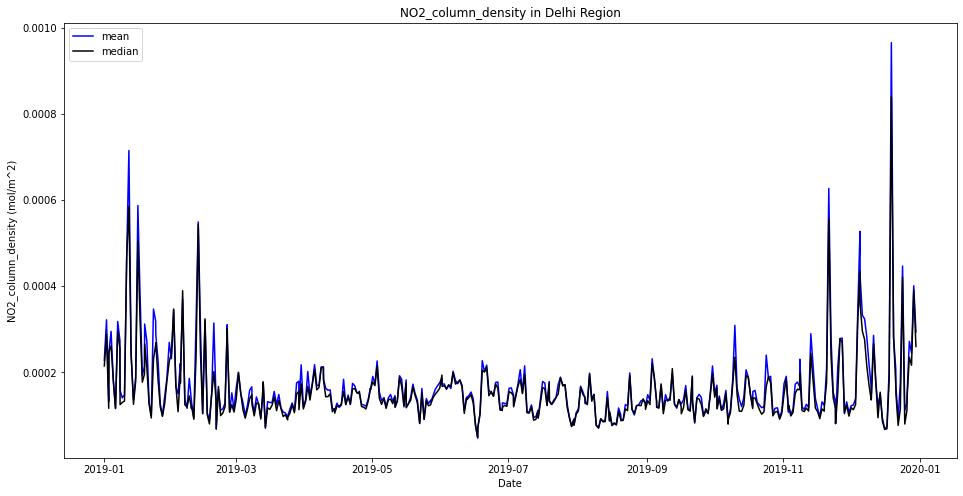

In [25]:
plot_datewise(mean_df=no2_mean,
                 band='NO2_column_density')

**SO2 Density**

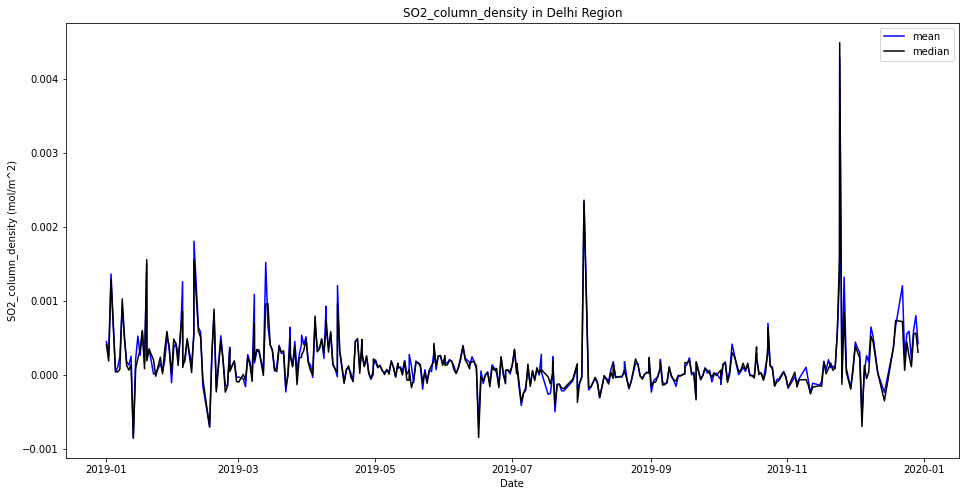

In [26]:
plot_datewise(mean_df=so2_mean,
                 band='SO2_column_density')

**CO density**

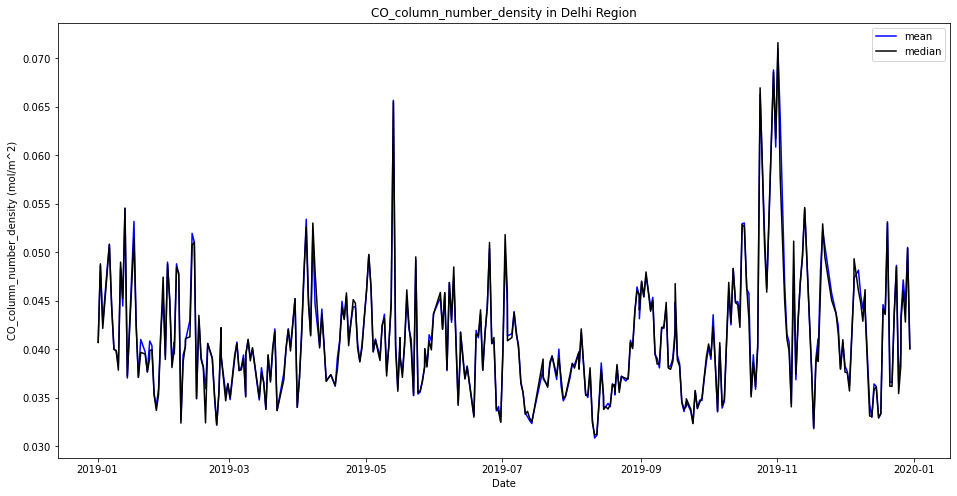

In [27]:
plot_datewise(mean_df=co_mean,
                 band='CO_column_number_density')

**Aerosol Index**

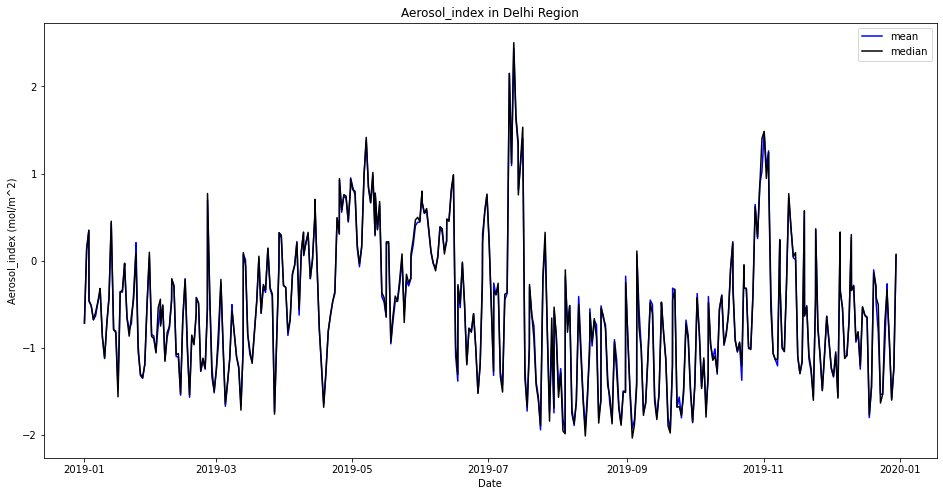

In [28]:
plot_datewise(mean_df=ai_mean,
                 band='Aerosol_index')

# Plotting Histograms

Nitrogen Dioxide Column density


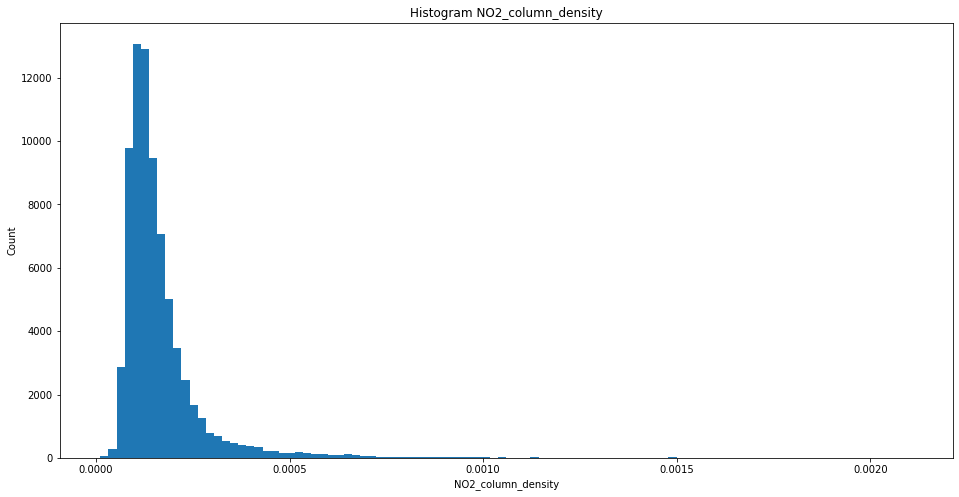

In [29]:
print('Nitrogen Dioxide Column density')
plot_hist(arr=no2_df['NO2_column_number_density'],
              label='NO2_column_density')

Sulfur Dioxide Column density


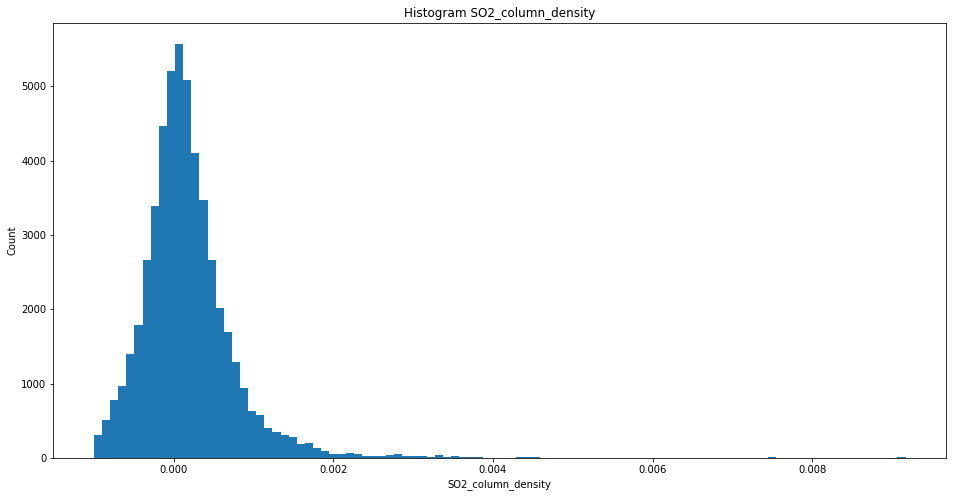

In [30]:
print('Sulfur Dioxide Column density')
plot_hist(arr=so2_df['SO2_column_number_density'],
              label='SO2_column_density')

Carbon Mono-oxide Column density


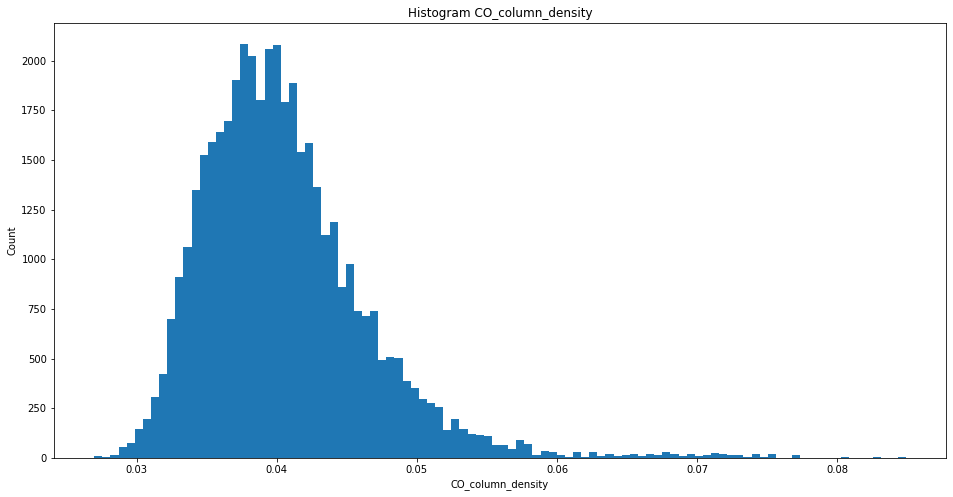

In [31]:
print('Carbon Mono-oxide Column density')
plot_hist(arr=co_df['CO_column_number_density'],
              label='CO_column_density')

Absorbing Aerosol Index


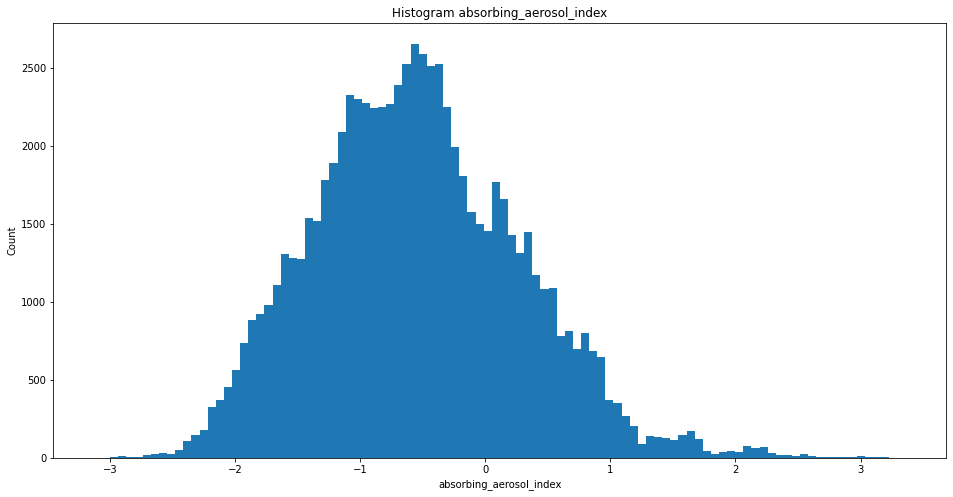

In [32]:
print('Absorbing Aerosol Index')
plot_hist(arr=aero_in_df['absorbing_aerosol_index'],
              label='absorbing_aerosol_index')

# Visualize average monthly variations

Mean Monthly NO2


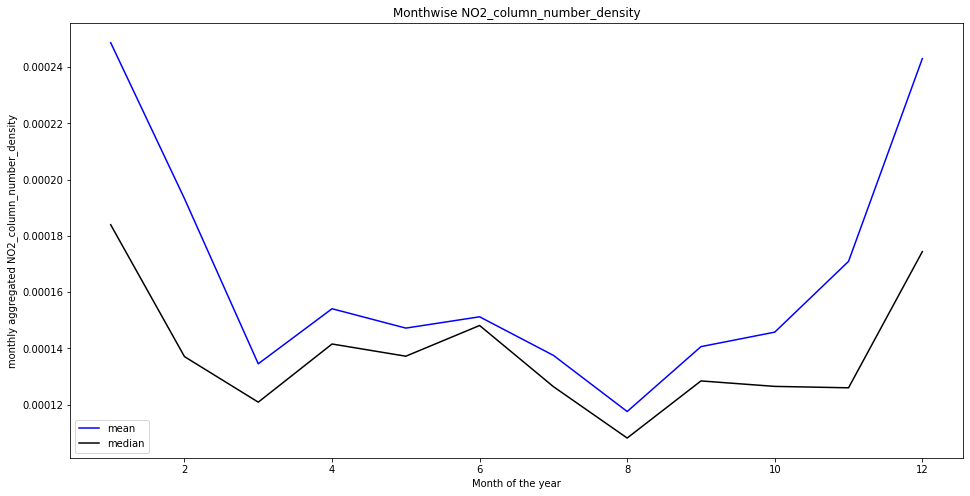

In [33]:
print('Mean Monthly NO2')
plot_monthwise(df=no2_df,
                  band='NO2_column_number_density',
                  ax1=None)

Mean Monthly SO2


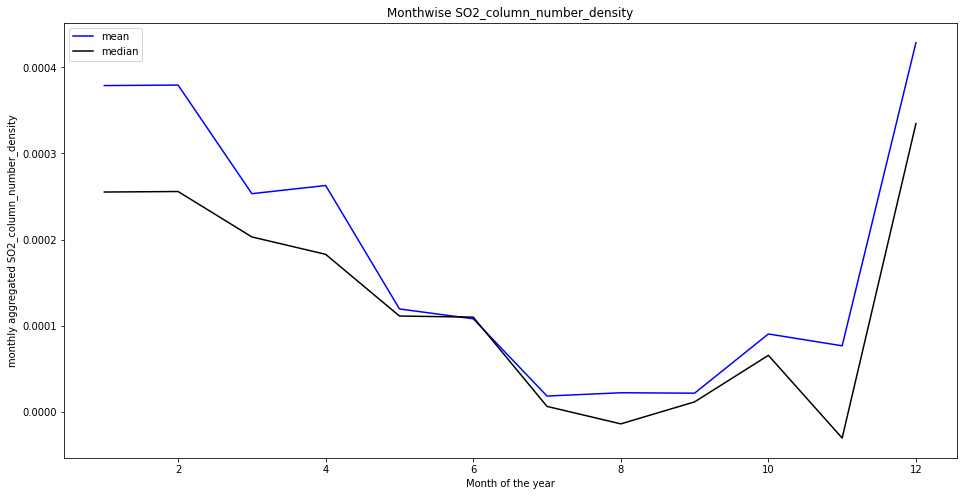

In [34]:
print('Mean Monthly SO2')
plot_monthwise(df=so2_df,
                  band='SO2_column_number_density',
                  ax1=None)

Mean Monthly CO


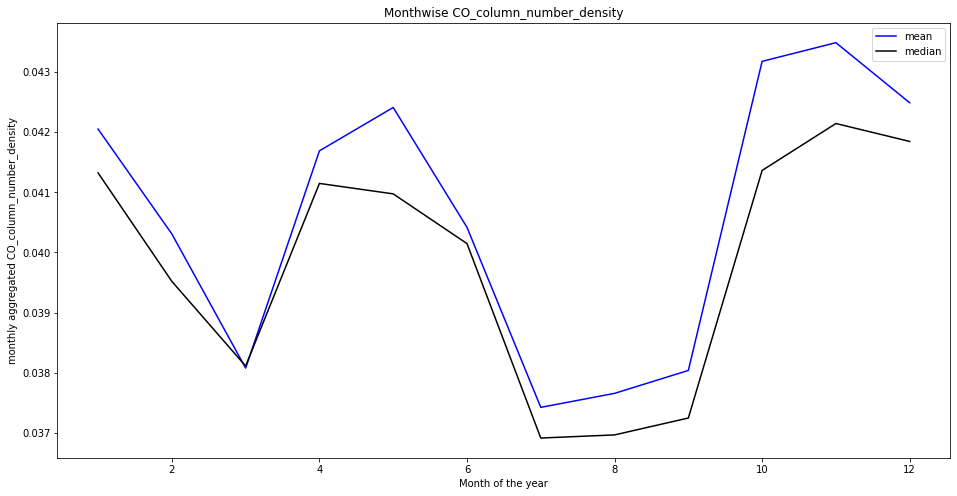

In [35]:
print('Mean Monthly CO')
plot_monthwise(df=co_df,
                  band='CO_column_number_density',
                  ax1=None)

Mean Monthly UV aerosol Index


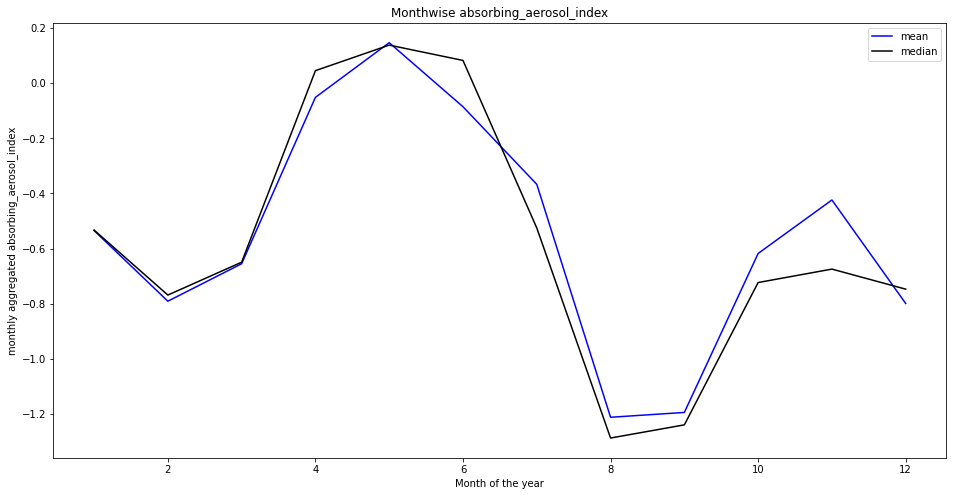

In [36]:
print('Mean Monthly UV aerosol Index')

plot_monthwise(df=aero_in_df,
                  band='absorbing_aerosol_index',
                  ax1=None)